# Kloppy

In [2]:
%load_ext autoreload
%autoreload 2

from kloppy import sportec
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mplsoccer import Pitch
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm
pd.set_option('display.max_columns', None)  # 모든 열 출력
from unravel.soccer import KloppyPolarsDataset

import os 
import pickle
import sys

sys.path.append(os.path.abspath(".."))
from pressing_intensity import CustomPressingIntensity
from visualization import plot_single_frame_positions, plot_window_frame_positions

coordinates = "secondspectrum"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def _normalize_coordinate_direction(df, home_team_id):
    """
    Normalizes the coordinate system within the DataFrame to ensure the home team
    always attacks in a consistent direction (e.g., left-to-right).
    Modifies the DataFrame based on period and initial home team orientation.

    Args:
        df (pd.DataFrame): The tracking DataFrame to process. Must contain
                            'period_id', 'frame_id', 'x', 'y', 'team_id' columns.
                            Will also flip 'vx', 'vy', 'ax', 'ay' if they exist.
        home_team_id (str): The team ID of the home team.

    Returns:
        pd.DataFrame: A DataFrame with normalized coordinate directions.
                        (Does not modify the input df directly, works on a copy).
    """
    cols_to_flip = ['x', 'y', 'vx', 'vy', 'ax', 'ay']
    df_normalized = df.copy()
    # --- 1. Unify direction for the second half ---
    # Create a mask for the second half (period_id == 2)
    second_half_mask = df_normalized['period_id'] == 2

    # List of kinematic columns (vectors) to flip along with coordinates
    

    # Flip the sign of coordinates and related vectors for second-half data
    for col in cols_to_flip:
        if col in df_normalized.columns:
            # Only attempt sign flip if the column is not of object type
            if df_normalized[col].dtype != 'object':
                df_normalized.loc[second_half_mask, col] = -df_normalized.loc[second_half_mask, col]
            else:
                # Handle object type columns (e.g., do nothing)
                pass
    
    # --- 2. Check home team attack direction and flip all if necessary ---
    # Find the first frame ID in the first period (period_id == 1)
    first_period_frames = df_normalized[df_normalized['period_id'] == 1]['frame_id']
    if not first_period_frames.empty:
        first_frame_idx = first_period_frames.unique()[0]
        first_frame_df = df_normalized[(df_normalized['period_id'] == 1) & (df_normalized['frame_id'] == first_frame_idx) & (df_normalized['team_id'] != 'ball')].copy()

        if not first_frame_df.empty and not first_frame_df['x'].isna().all():
            # Find the team ID of the entity with the minimum 'x' value (usually leftmost player/ball)
            try:
                min_x_team_id = first_frame_df.loc[first_frame_df['x'].idxmin(), 'team_id']

                # If the leftmost entity is not the home team, assume home team is attacking right-to-left
                # In this case, flip all coordinates and vectors for the entire match.
                if min_x_team_id != home_team_id:
                    for col in cols_to_flip:
                        if col in df_normalized.columns:
                            if df_normalized[col].dtype != 'object':
                                # Use .loc to modify the DataFrame slice directly
                                df_normalized.loc[:, col] = -df_normalized.loc[:, col]
                            else:
                                pass
            except ValueError:
                # Handle cases where idxmin() fails (e.g., all 'x' values are NaN)
                print(f"Warning: Could not determine minimum 'x' value for frame {first_frame_idx}. Skipping orientation check.")
        else:
            print(f"Warning: No valid data found for the first frame ({first_frame_idx}) of period 1. Skipping main orientation check.")
    else:
        print("Warning: No data found for period 1. Skipping main orientation check.")
    return df_normalized


In [24]:
data_path = "/data/MHL/bepro/processed/"
results = []
if os.path.exists(data_path):
    match_id_lst = os.listdir(data_path)
    total_dict = {match_id : {} for match_id in match_id_lst}
    for match_id in match_id_lst:
        print(f"Load {match_id}")
        with open(f"{data_path}/{match_id}/{match_id}_processed_dict.pkl", "rb") as f:
            match_dict = pickle.load(f)
        tracking_df = match_dict['tracking_df']
        teams_dict = match_dict['teams']
        with open(f"{data_path}/{match_id}/{match_id}_presing_intensity.pkl", "rb") as f:
            pressing_df = pickle.load(f)

        total_df = pd.merge(tracking_df, pressing_df, on=['game_id', 'period_id', 'timestamp', 'frame_id'], how='left')
        total_df = _normalize_coordinate_direction(total_df, teams_dict['Home']['pID'].iloc[0])
        total_dict[match_id] = {}
        total_dict[match_id]['tracking_df'] = total_df
        total_dict[match_id]['Home'] = match_dict['teams']['Home']
        total_dict[match_id]['Away'] = match_dict['teams']['Away']
        break
else:
    match_id_lst = [x.split("-")[-1] for x in os.listdir("/data/MHL/dfl-spoho/raw/")]
    totals = {x : {} for x in match_id_lst}
    for match_id in match_id_lst:
        if match_id != 'J03WQQ': continue
        with open(f"/data/MHL/pressing-intensity/{match_id}.pkl", "rb") as f:
            output = pickle.load(f)
        kloppy_dataset = sportec.load_open_tracking_data(
        match_id=match_id, coordinates=coordinates
        )
        home_team, away_team = kloppy_dataset.metadata.teams
        
        dataset = KloppyPolarsDataset(kloppy_dataset=kloppy_dataset, orient_ball_owning=False)
        model = CustomPressingIntensity(dataset=dataset)
        total_df = model.dataset.to_pandas()
        # if np.array_equal(np.unique(total_df['frame_id'].value_counts().values), np.array([23])):
        #     continue
        total_df = pd.merge(total_df, output, on=['game_id', 'period_id', 'timestamp', 'frame_id'], how='left')
        mask = total_df['period_id'] == 2
        total_df.loc[mask, 'x'] = -total_df.loc[mask, 'x']
        total_df.loc[mask, 'y'] = -total_df.loc[mask, 'y']

        totals[match_id]['df'] = total_df
        totals[match_id]['home'] = home_team
        totals[match_id]['away'] = away_team
        break

        # # Check when ball carrier is pressed (Pressing Intensity higher than 0.7)
        # pressed_dict = dict()
        # ball_carrier_df = total_df[total_df['is_ball_carrier']==True]
        # ball_carrier_df.sort_values('frame_id', inplace=True)
        
        # for idx, row in ball_carrier_df.iterrows():
        #     if len(np.where(row['columns'] == row['id'])[0]) != 0:
        #         id_loc = np.where(row['columns'] == row['id'])[0]
        #         pressing_values = [x[id_loc] for x in row['probability_to_intercept']]
        #     elif len(np.where(row['rows'] == row['id'])[0]) != 0:
        #         id_loc = np.where(row['rows'] == row['id'])[0]
        #         pressing_values = row['probability_to_intercept'][id_loc].tolist()[0].tolist()
        #     if max(pressing_values) > 0.7:
        #         pressed_dict[idx] = max(pressing_values)

        # pressed_df = ball_carrier_df.loc[list(pressed_dict.keys())]
        # pressed_df['max_pressing_values'] = list(pressed_dict.values())
        # pressed_df['is_consecutive'] = pressed_df['frame_id'].diff() < 50
        # results.append(pressed_df)

        # break

Load 126293


In [25]:
match_id = match_id_lst[0]
total_df = total_dict[match_id]['tracking_df']
home_team = total_dict[match_id]['Home']
away_team = total_dict[match_id]['Away']

In [26]:
# ball carrier에 대해 pressing intensity가 0.7보다 큰 경우 pressed_df 구성
pressed_dict = {}
ball_carrier_df = total_df[total_df['is_ball_carrier'] == True].copy()
ball_carrier_df.sort_values('frame_id', inplace=True)

In [39]:
for idx, row in tqdm(ball_carrier_df.iterrows(), desc= "Get Pressing Intensity"):
    if len(np.where(row['columns'] == row['id'])[0]) != 0:
        axis = 'columns'
        id_loc = np.where(row[axis] == row['id'])[0]
        pressing_values = [x[id_loc] for x in row['probability_to_intercept']]
            
    elif len(np.where(row['rows'] == row['id'])[0]) != 0:
        axis = 'rows'
        id_loc = np.where(row['rows'] == row['id'])[0]
        # 다중 list nested 구조로 되어 있을 수 있으므로 tolist()를 두 번 적용
        pressing_values = row['probability_to_intercept'][id_loc].tolist()[0].tolist()    
    else:
        continue
    if max(pressing_values) > 0.7:
        pressed_dict[idx] = {}
        pressed_dict[idx]['pressing_value'] = max(pressing_values)
        max_idx = pressing_values.index(max(pressing_values))
        pressed_dict[idx]['pressing_player'] = row[axis][max_idx]

Get Pressing Intensity: 0it [00:00, ?it/s]

Get Pressing Intensity: 124018it [00:05, 21982.68it/s]


In [ ]:
pressed_df = ball_carrier_df.loc[list(pressed_dict.keys())].copy()
pressed_df['pressing_values'] = [d['pressing_value'] for d in pressed_dict.values()]
pressed_df['pressing_player'] = [d.get('pressing_player') for d in pressed_dict.values()]            

# frame_id 차이가 50 프레임 이상인 경우 새로운 시퀀스로 판단 (즉, 연속된 pressed 행이 아닐 경우)
pressed_df['frame_diff'] = pressed_df['frame_id'].diff()
pressed_df['sequence_id'] = (pressed_df['frame_diff'] > 50).cumsum()

In [ ]:
# 각 시퀀스별 마지막 frame을 기준으로 X와 Y를 설정하기 위해 마지막 frame 정보를 구함
first_frames = pressed_df.groupby('sequence_id', as_index=False)[['frame_id', 'pressing_player']].first()

# 각 마지막 frame에 대해, 이후 125 frame 내에 ball_owning_team의 값이 변경되었는지 체크하여 label(Y)을 설정
def check_change(frame_id, window=125):
    subset = total_df[(total_df['frame_id'] >= frame_id) & (total_df['frame_id'] < frame_id + window)]
    return subset['ball_owning_team_id'].nunique() > 1
first_frames['ball_ownership_changed'] = first_frames['frame_id'].apply(check_change)

In [94]:
first_frames.head()

,sequence_id,frame_id,pressing_player,ball_ownership_changed
0,0,10073,DFL-OBJ-002FXT,False
1,1,10198,DFL-OBJ-0000F8,True
2,2,10514,DFL-OBJ-0028T3,True
3,3,10589,DFL-OBJ-0001HW,True
4,4,11217,DFL-OBJ-002FXT,False


In [ ]:
import torch
sequence_length = 125
cols_to_flip = ['x', 'y', 'vx', 'vy', 'ax', 'ay']
feature_cols = ['x', 'y', 'vx', 'vy', 'ax', 'ay']
num_agents = 23

all_features_seqs = []
all_pressintensity_seqs = []
all_labels = []
all_presser_ids = []
all_agent_orders = []

for _, row in tqdm(first_frames.iterrows(), desc= "Get Samples"):
    frame_id = row['frame_id']
    label = int(row['ball_ownership_changed'])
    pressing_player = row['pressing_player']
    X_slice = total_df[total_df['frame_id'].isin(range(frame_id - sequence_length, frame_id))].copy()
    # Always press left -> right
    # If pressed players team is home, flip
    if X_slice.loc[(X_slice['frame_id']==frame_id-1) & (X_slice['is_ball_carrier']==True)]['team_id'].iloc[0] == home_team.team_id:
        for col in cols_to_flip:
            X_slice.loc[:, col] = -X_slice.loc[:, col]

    agents_cols = X_slice[pd.isna(X_slice['columns'])==False]['columns'].values[0]
    agents_rows = X_slice[pd.isna(X_slice['rows'])==False]['rows'].values[0]
    agents_order = agents_cols.tolist() + agents_rows.tolist()
    
    # Ensure the player IDs are consistent and match num_agents (23 players)
    num_unique_agents = X_slice['id'].nunique()
    frame_lst = X_slice['frame_id'].unique()
    if num_unique_agents < num_agents:
        # Find the missing players
        num_missing_agents = num_agents - num_unique_agents
    
        # Add missing player rows with zero values for each frame in X_slice
        missing_rows = []
        for missing_player in range(num_missing_agents):
            for frame in frame_lst:
                missing_row = {col: 0 for col in X_slice.columns}  # Fill all columns with 0
                missing_row['id'] = f"Missing_{missing_player}"  # Set the 'id' to the missing player's id
                missing_row['frame_id'] = frame  # Set the frame_id for the current frame in the sequence
                missing_rows.append(missing_row)
            agents_order.append(f"Missing_{missing_player}") 

        # Create a DataFrame for the missing rows and append to the slice
        missing_df = pd.DataFrame(missing_rows)
        X_slice = pd.concat([X_slice, missing_df], ignore_index=True)
    
    agents_order.append('ball')

    X_slice.loc[:, 'id'] = pd.Categorical(X_slice['id'], categories=agents_order, ordered=True)
    # Sort the players by their ID to maintain a consistent order
    X_slice = X_slice.sort_values(by=['frame_id', 'id'])
    if len(frame_lst) < sequence_length:
        pad_len = sequence_length - len(X_slice['frame_id'].unique())
        pad_tensor = torch.zeros(pad_len * num_agents, len(feature_cols))
        x_tensor = torch.tensor(X_slice[feature_cols].values, dtype=torch.float32)
        x_tensor = torch.cat([pad_tensor, x_tensor], dim=0)
        X_slice_pressing = X_slice[X_slice['is_ball_carrier']==True]['probability_to_intercept']
        X_slice_pressing = X_slice_pressing[pd.isna(X_slice_pressing)==False]
        pressing_pad_len = sequence_length - len(X_slice_pressing)
        pressing_intensity_tensor = torch.tensor(np.stack(X_slice_pressing.map(lambda x: np.stack(x)).values), dtype=torch.float32)
        pad_pressing_tensor = torch.zeros(pressing_pad_len, pressing_intensity_tensor.shape[1], pressing_intensity_tensor.shape[2])
        pressing_intensity_tensor = torch.cat([pad_pressing_tensor, pressing_intensity_tensor], dim=0)
    else:
        x_tensor = torch.tensor(X_slice[feature_cols].values, dtype=torch.float32)
        X_slice_pressing = X_slice[X_slice['is_ball_carrier']==True]['probability_to_intercept']
        X_slice_pressing = X_slice_pressing[pd.isna(X_slice_pressing)==False]
        pressing_pad_§len = sequence_length - len(X_slice_pressing)
        pressing_intensity_tensor = torch.tensor(np.stack(X_slice_pressing.map(lambda x: np.stack(x)).values), dtype=torch.float32)
        if pressing_pad_len > 0:
            pad_pressing_tensor = torch.zeros(pressing_pad_len, pressing_intensity_tensor.shape[1], pressing_intensity_tensor.shape[2])
            pressing_intensity_tensor = torch.cat([pad_pressing_tensor, pressing_intensity_tensor], dim=0)    
        
    x_tensor = x_tensor.reshape(sequence_length, num_agents, len(feature_cols))
    y_tensor = torch.tensor(label, dtype=torch.long)
    
    all_features_seqs.append(x_tensor)
    all_pressintensity_seqs.append(pressing_intensity_tensor)
    all_labels.append(y_tensor)
    all_presser_ids.append(pressing_player)    
    all_agent_orders.append(agents_order)


Get Samples: 414it [00:53,  7.71it/s]


IndexError: single positional indexer is out-of-bounds

In [71]:
_, row = next(iter(first_frames.iterrows()))
sequence_length = 125
frame_id = row['frame_id']
label = int(row['ball_ownership_changed'])
X_slice = total_df[total_df['frame_id'].isin(range(frame_id - sequence_length, frame_id))]


In [77]:
X_slice.loc[(X_slice['frame_id']==frame_id-1) & (X_slice['is_ball_carrier']==True)]['team_id'].iloc[0]

'DFL-CLU-00000P'

In [42]:
if X_slice['ball_owning_team_id'].iloc[-1] == home_team.team_id:
    X_slice.loc[:, 'x'] = -X_slice.loc[:, 'x']
    X_slice.loc[:, 'y'] = -X_slice.loc[:, 'y']

In [31]:
first_frame_df = total_df[(total_df['period_id'] == 1) & (total_df['frame_id'] == 10000)]
first_frame_df.loc[first_frame_df['x'].idxmin(), 'team_id'] == home_team.team_id

False

In [ ]:
total_df.loc[:, 'x'] = -total_df.loc[:, 'x']
total_df.loc[:, 'y'] = -total_df.loc[:, 'y']


/home/ubuntu/MHL/exPress/exPressV2/visualization.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_df.sort_values("frame_id", inplace=True)


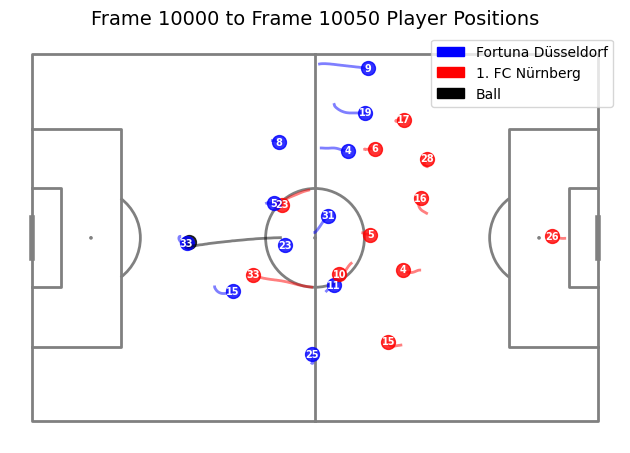

In [35]:
# Set up pitch using kloppy_dataset metadata (예시)
pitch = Pitch(
    pitch_type='secondspectrum', 
    pitch_length=kloppy_dataset.metadata.pitch_dimensions.pitch_length,
    pitch_width=kloppy_dataset.metadata.pitch_dimensions.pitch_width,
    pitch_color='white', 
    line_color='gray'
)

# 호출 예시 (home_team와 away_team 객체가 미리 정의되어 있다고 가정)
plot_window_frame_positions(total_df, period_id=1,start_frame_idx=10000, end_frame_idx=10050,
                             pitch=pitch, home_team_info=home_team, away_team_info=away_team)

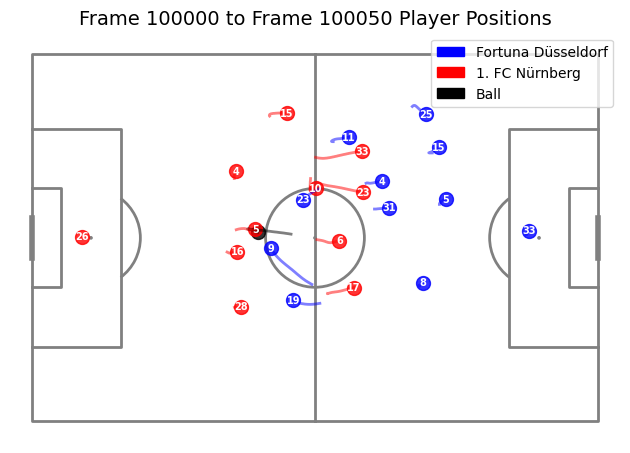

In [23]:
# Set up pitch using kloppy_dataset metadata (예시)
pitch = Pitch(
    pitch_type='secondspectrum', 
    pitch_length=kloppy_dataset.metadata.pitch_dimensions.pitch_length,
    pitch_width=kloppy_dataset.metadata.pitch_dimensions.pitch_width,
    pitch_color='white', 
    line_color='gray'
)

# 호출 예시 (home_team와 away_team 객체가 미리 정의되어 있다고 가정)
plot_window_frame_positions(total_df, period_id=2,start_frame_idx=100000, end_frame_idx=100050,
                             pitch=pitch, home_team_info=home_team, away_team_info=away_team)

In [126]:
# ball carrier에 대해 pressing intensity가 0.7보다 큰 경우 pressed_df 구성
ball_carrier_df = total_df[total_df['is_ball_carrier'] == True].copy()
ball_carrier_df.sort_values('frame_id', inplace=True)
ball_carrier_df.head()

,period_id,timestamp,frame_id,ball_state,id,x,y,z,team_id,position_name,game_id,vx,vy,vz,v,ax,ay,az,a,ball_owning_team_id,is_ball_carrier,time_to_intercept,probability_to_intercept,columns,rows
1329849,1,0 days 00:00:00,10000,alive,DFL-OBJ-002GNL,0.41,-0.20,0.0,DFL-CLU-00000H,UNK,DFL-MAT-J03WQQ,-0.250000,0.035714,0.0,0.252538,0.000000,0.000000,0.0,0.000000,DFL-CLU-00000H,True,"[[3.681494532523284, 3.0742303981294876, 3.088...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R..."
1329850,1,0 days 00:00:00.040000,10001,alive,DFL-OBJ-002GNL,0.40,-0.20,0.0,DFL-CLU-00000H,UNK,DFL-MAT-J03WQQ,-0.142857,0.071429,0.0,0.159719,2.678571,0.892857,0.0,2.823462,DFL-CLU-00000H,True,"[[3.6527002926125043, 3.1476350866834393, 3.42...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R..."
12341,1,0 days 00:00:00.080000,10002,alive,DFL-OBJ-00008K,-0.44,-9.04,0.0,DFL-CLU-00000P,ST,DFL-MAT-J03WQQ,-1.580357,0.964286,0.0,1.851317,-8.705357,5.357143,0.0,6.000000,DFL-CLU-00000P,True,"[[4.216526463521921, 3.3627067567564977, 2.986...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R..."
1329852,1,0 days 00:00:00.120000,10003,alive,DFL-OBJ-002GNL,0.39,-0.18,0.0,DFL-CLU-00000H,UNK,DFL-MAT-J03WQQ,0.071429,0.142857,0.0,0.159719,2.678571,0.892857,0.0,2.823462,DFL-CLU-00000H,True,"[[3.5982805003379834, 3.3098630168641776, 4.14...","[[0.0, 0.0, 2.3425141989264435e-05, 0.0, 0.0, ...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R..."
1329853,1,0 days 00:00:00.160000,10004,alive,DFL-OBJ-002GNL,0.40,-0.18,0.0,DFL-CLU-00000H,UNK,DFL-MAT-J03WQQ,0.178571,0.178571,0.0,0.252538,2.678571,0.892857,0.0,2.823462,DFL-CLU-00000H,True,"[[3.5744096942464703, 3.4344235838662973, 4.60...","[[0.0, 0.0, 3.660144353460367e-06, 0.0, 0.0, 0...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R..."


In [127]:
for idx, row in tqdm(ball_carrier_df.iterrows(), desc= "Get Pressing Intensity"):
    if len(np.where(row['columns'] == row['id'])[0]) != 0:
        id_loc = np.where(row['columns'] == row['id'])[0]
        pressing_values = [x[id_loc] for x in row['probability_to_intercept']]
    elif len(np.where(row['rows'] == row['id'])[0]) != 0:
        id_loc = np.where(row['rows'] == row['id'])[0]
        # 다중 list nested 구조로 되어 있을 수 있으므로 tolist()를 두 번 적용
        pressing_values = row['probability_to_intercept'][id_loc].tolist()[0].tolist()
    else:
        continue
    if max(pressing_values) > 0.7:
        pressed_dict[idx] = max(pressing_values)

Get Pressing Intensity: 0it [00:00, ?it/s]

Get Pressing Intensity: 84291it [00:11, 7324.78it/s] 


In [128]:
pressed_df = ball_carrier_df.loc[list(pressed_dict.keys())].copy()
pressed_df['max_pressing_values'] = list(pressed_dict.values())
# frame_id 차이가 50 프레임 이상인 경우 새로운 시퀀스로 판단 (즉, 연속된 pressed 행이 아닐 경우)
pressed_df['frame_diff'] = pressed_df['frame_id'].diff()
pressed_df['sequence_id'] = (pressed_df['frame_diff'] > 50).cumsum()
# 각 시퀀스별 마지막 frame을 기준으로 X와 Y를 설정하기 위해 마지막 frame 정보를 구함
last_frames = pressed_df.groupby('sequence_id', as_index=False)['frame_id'].last()
pressed_df.head()

,period_id,timestamp,frame_id,ball_state,id,x,y,z,team_id,position_name,game_id,vx,vy,vz,v,ax,ay,az,a,ball_owning_team_id,is_ball_carrier,time_to_intercept,probability_to_intercept,columns,rows,max_pressing_values,frame_diff,sequence_id
1245544,1,0 days 00:00:01.880000,10047,alive,DFL-OBJ-002GN4,-20.61,-3.65,0.0,DFL-CLU-00000H,RCB,DFL-MAT-J03WQQ,2.107143,-0.321429,0.0,2.131518,7.142857,-3.178013e-13,0.0,6.000000,DFL-CLU-00000H,True,"[[4.019773424181642, 7.136662639523909, 10.824...","[[0.0, 1.3584586086236587e-10, 4.7651969584323...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R...",[0.8565721932430506],NaN,0
1245545,1,0 days 00:00:01.920000,10048,alive,DFL-OBJ-002GN4,-20.51,-3.67,0.0,DFL-CLU-00000H,RCB,DFL-MAT-J03WQQ,2.285714,-0.321429,0.0,2.308204,4.464286,0.000000e+00,0.0,4.464286,DFL-CLU-00000H,True,"[[4.046497049903188, 7.134183604047539, 10.899...","[[3.4862038572708374e-05, 1.3721005902651517e-...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R...",[0.8656423868667901],1.0,0
1245546,1,0 days 00:00:01.960000,10049,alive,DFL-OBJ-002GN4,-20.41,-3.69,0.0,DFL-CLU-00000H,RCB,DFL-MAT-J03WQQ,2.571429,-0.321429,0.0,2.591440,7.142857,0.000000e+00,0.0,6.000000,DFL-CLU-00000H,True,"[[4.034864522665217, 7.187265144734022, 10.994...","[[3.653547356413691e-05, 1.1078142407270247e-1...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R...",[0.8729214053566801],1.0,0
1245547,1,0 days 00:00:02,10050,alive,DFL-OBJ-002GN4,-20.29,-3.70,0.0,DFL-CLU-00000H,RCB,DFL-MAT-J03WQQ,2.750000,-0.321429,0.0,2.768721,4.464286,0.000000e+00,0.0,4.464286,DFL-CLU-00000H,True,"[[4.04008665525496, 7.23273650741325, 11.05847...","[[3.5774514688700784e-05, 9.222942897437064e-1...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R...",[0.8666350874823968],1.0,0
1245548,1,0 days 00:00:02.040000,10051,alive,DFL-OBJ-002GN4,-20.18,-3.71,0.0,DFL-CLU-00000H,RCB,DFL-MAT-J03WQQ,2.928571,-0.321429,0.0,2.946158,4.464286,-3.178013e-13,0.0,4.464286,DFL-CLU-00000H,True,"[[4.060021675358669, 7.282988174640193, 11.035...","[[3.301252810312965e-05, 7.531893898175411e-11...","[DFL-OBJ-0002EL, DFL-OBJ-0026V5, DFL-OBJ-0027Q...","[DFL-OBJ-00008K, DFL-OBJ-0000NZ, DFL-OBJ-0026R...",[0.858351898524591],1.0,0


In [129]:
# 각 마지막 frame에 대해, 이후 125 frame 내에 ball_owning_team의 값이 변경되었는지 체크하여 label(Y)을 설정
def check_change(frame_id, window=125):
    subset = total_df[(total_df['frame_id'] >= frame_id) & (total_df['frame_id'] < frame_id + window)]
    return subset['ball_owning_team_id'].nunique() > 1
last_frames['ball_ownership_changed'] = last_frames['frame_id'].apply(check_change)

In [60]:
last_frames.tail()

,sequence_id,frame_id,ball_ownership_changed
390,390,171429,False
391,391,171727,False
392,392,171878,True
393,393,171935,True
394,394,172837,False


In [44]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

features = []
labels = []
for i in range(len(dataset)):
    x_tensor, y_tensor = dataset[i]
    # Flatten the sequence data: shape (sequence_length, num_features) -> (sequence_length*num_features,)
    feature_vector = x_tensor.flatten().numpy()
    features.append(feature_vector)
    labels.append(y_tensor.item())

In [45]:
X = np.array(features)
y = np.array(labels)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Create XGBoost DMatrix objects for train and test sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost training parameters
params = {
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': 'auc',            # evaluation metric: AUC
    'max_depth': 6,                  # maximum depth of trees
    'eta': 0.1,                      # learning rate
    'seed': 42
}

# Specify the watchlist to evaluate performance on training and test sets during training
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
num_rounds = 100


In [47]:
# Train XGBoost model with early stopping on the evaluation set
bst = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)

# Get predictions on the test set
y_pred = bst.predict(dtest)
y_pred_label = (y_pred > 0.5).astype(int)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred_label)
auc = roc_auc_score(y_test, y_pred)

print("Test Accuracy: {:.4f}".format(accuracy))
print("Test AUC: {:.4f}".format(auc))

/home/ubuntu/miniforge3/envs/mh/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.98111	eval-auc:0.50246
[1]	train-auc:0.99200	eval-auc:0.53294
[2]	train-auc:0.99386	eval-auc:0.54280
[3]	train-auc:0.99771	eval-auc:0.58590
[4]	train-auc:0.99930	eval-auc:0.57882
[5]	train-auc:0.99985	eval-auc:0.56096
[6]	train-auc:0.99996	eval-auc:0.55757
[7]	train-auc:0.99996	eval-auc:0.55911
[8]	train-auc:1.00000	eval-auc:0.57143
[9]	train-auc:1.00000	eval-auc:0.56342
[10]	train-auc:1.00000	eval-auc:0.55049
[11]	train-auc:1.00000	eval-auc:0.55234
[12]	train-auc:1.00000	eval-auc:0.56096
Test Accuracy: 0.6235
Test AUC: 0.5536
